## Socio-emotional interactions on Twitter

### Data Crawling, Processing, Analysis and Basic Plots

In this notebook, we explain how we get required datasets from Twitter API as well as the processing to answer our research questions.

Main idea:
1. In our research, we want to perform sentiment analysis on twitter users based on their tweets content.
2. To perform such sentiment analysis, we need to crawl the content of tweets each user post.

Problems we encounter in data crawling and solutions:
1. **P**: Twitter API has rate limit. **Sol**: We divide task into several small tasks and use 2 different API keys to crawl data in parallel.
2. **P**: A tweet is a retweet. **Sol**: Tweepy will return a truncated tweet text if it's a retweet, but we will crawl the full text for retweet as well.
3. **P**: Some user set their main pages as private. **Sol**: We will ignore those users that we can not get data.
4. **P**: Some user has small number of tweets. **Sol**: We will only consider those who has at least 100 tweets so sentiment analysis will be meaningful.
5. **P**: Some user has non-english tweets which is difficult to perform sentiment analysis. **Sol**: We ignore those non-english tweets and only perform sentiment analysis on english tweets.

Note: 
1. Results of some codes will not show in this notebook because these codes take **several days** to run on the server.
2. Original codes are seperated into several files and run on a server. We combine them in this notebook.

Here is the google drive link of data we get:

https://drive.google.com/drive/folders/1DOi3W364wSNYE-KrZUpMOxsuQQdrT8tb?usp=sharing

#### 1. Import required packages

Note: TweetMiner is a class written by us to set up all required parameters in getting contents of tweets

In [51]:
# General:
import tweepy           # A better interface to access Twitter's API
import pandas as pd     
import numpy as np      
from textblob import TextBlob # NLP packages to do sentiment analysis
import re
from TweetMiner import TweetMiner # A class developed by us to set up all required parameters to get data
import networkx as nx # Package to plot a network graph
# For plotting and visualization:
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### 2. Get user id from orignal dataset

In [ ]:
EgoTimelines = pd.read_csv('EgoTimelines.txt', delimiter="\t", encoding = "ISO-8859-1")

user_id = EgoTimelines.drop_duplicates(subset=['id'])
user_id =  user_id[['id']]
user_id_list = user_id.reset_index(drop=True)
user_id_list.to_csv('user_id.csv')

#### 3. Select those users are still active in 2020

Step 1: Check the last time user post tweet (or reweet)

Step 2: Select those who are still active in 2020

In [ ]:
# Twitter API access keys

# Consume:
CONSUMER_KEY    = 'ao8r4omXvWJVqdDQDmHNTQro1'
CONSUMER_SECRET = 'jWpR3zUxY7s6jlelIYZbQ2CcIpVjU7bETjRY7QAr3gshDpLo8C'

# Access:
ACCESS_TOKEN  = '1333883939056922624-yusW9NmGIO9YEcGaloDxAfk7q4CsxA'
ACCESS_SECRET = 'Wc5hinGMMtDlzf3pQCTlZ8HfqXCVJKmgVZgioFHz4d36b'

# We import our access keys:
#from credentials import *    # This will allow us to use the keys as variables

# API's setup:
def twitter_setup():
    """
    Utility function to setup the Twitter's API
    with our access keys provided.
    """
    # Authentication and access using keys:
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

    # Return API with authentication:
    api = tweepy.API(auth, wait_on_rate_limit=True)
    return api

#Get user last update time
def getUserLastTweetTime(extractor, user_id_list):
    N = len(user_id_list['id'])
    date_array = np.empty(N,dtype=object)
    for ind, user_id in enumerate(user_id_list['id']):
        try:
            last_tweet = extractor.user_timeline(user_id,count=1) #get last tweet
            if len(last_tweet)>0:
                date_array[ind] = last_tweet[0].created_at
        except tweepy.TweepError:
            pass
        
    return date_array

In [ ]:
#Get last update time for each user
last_time_update = getUserLastTweetTime(extractor = extractor, user_id_list = user_id_list)

#select user still active in 2020
user_id_active_2020 = user_id_list.loc[[date.year == 2020 for date in last_time_update]]
user_id_active_2020.to_csv("user_id_active_2020.csv")

#### 4. Get tweets of selected users
    
Step 1: For each user, we crawl up to 200 tweets. If they have more than 200 tweets, we only get 200 tweets.
   
Step 2: If a 'tweet' is a 'retweet', we will also get retweet text.

Note: We collect tweet id,user id,retweet count,create time, full text, language for each tweet.

In [ ]:
user_list = pd.read_csv('./user_id_active_2020.csv')
miner=TweetMiner(result_limit=200)
mined_tweets_dict = dict()
column_names = ['tweet_id','user_id','retweet_count','text','created_at','favourite_count','language','retweet_text']
tweets = pd.DataFrame(columns = column_names)

for ind,user_id in enumerate(user_list['id']):
    N = len(user_list)
    print("Current Progress: {:.3f}%".format(100*ind/(N-1)))
    try:
        mined_tweets = miner.mine_user_tweets(user_id=user_id)
        tweets = tweets.append(pd.DataFrame(mined_tweets),ignore_index = True)
    except tweepy.TweepError as e:
        print(f'{user_id} could not be processed because {e}')
        
tweets.to_pickle('user_tweets.pkl',compression='zip')

#### 5. Select those who has at least 100  english tweets

Step 1: Select only english tweets.

Step 2: Select users with at least 100 english tweets.

In [ ]:
user_tweets = pd.read_pickle('user_tweets.pkl',compression='zip')

#Select english tweets
english_tweets = user_tweets.loc[test['language'] == 'en']

#Select user with at least 100 english tweets
bool_array = (english_tweets.groupby(['user_id']).size()>=100).values
user_en_over_100 = (english_tweets.groupby(['user_id']).size()>=100).index[bool_array]
pd.DataFrame(user_en_over_100.values,columns = ['id']).to_csv('user_en_over_100.csv',index=False)

#### 6. Split selected valid user id into 80 groups manually
    
Step 1: We split active users into 80 groups manually.

Note: This help us to reduce our major task into small tasks and handle them in parallel.

#### 7. Get 'friends' (a.k.a following) list of selected users

Step 1: We get the friends list of each group of users and store them into groups.

In [ ]:
def getFollow(extractor,user_id):
    following_list_list = []
    for ind, id in enumerate(user_id['id']):
        try:
            following_list = extractor.friends_ids(id)
            following_list_list.extend(toTupleList(id,following_list))
        except tweepy.TweepError:
            pass
  
    return following_list_list

In [ ]:
N_splits = 80
split_user_id_list = [ pd.read_csv('./user_id_split_80/data/user_id_Group_'+str(i)+'.csv')
                      for i in range(N_splits)]
for group_id in range(0,80):
    following_list= getFollow(extractor=extractor,
                              user_id=split_user_id_list[group_id])
    pd.DataFrame(following_list,columns=['id','followingid'])\
    .to_csv('Group_'+str(group_id)+'_Following.csv',index=False)

#### 8. Get englisth tweets of 'friends'

Step 1: We check each group of 'friends' and get their englisth tweets.

Note: We run this code on server with 2 different API keys in parallel.

In [ ]:
def get_friends_tweets(key=1,range_left=0,range_right=0):
    miner = TweetMiner(result_limit = 200, key = key)
    column_names = ['tweet_id','user_id','retweet_count','text','created_at','favourite_count','language','retweet_text']
    valid_user = pd.read_csv('user_en_over_100.csv')
    for group_id in range(range_left,range_right):
        following_file_name = 'Group_'+str(group_id) + '_Following.csv'
        following_output_name = 'Group_'+str(group_id) + '_Following_Tweets.pkl'
        followings = pd.read_csv(following_file_name)
        
        tweets = pd.DataFrame(columns = column_names)
        valid_followings_bool = [(id in valid_user['id'].values) for id in followings['id']]
        
        for ind, user_id in enumerate(followings.loc[valid_followings_bool,'followingid']):
            N = np.sum(valid_followings_bool)
            if N>=2:
                print("Current Progress: {:.3f}%".format(100*ind/(N-1)))
            
            try:
                mined_tweets = miner.mine_user_tweets(user_id=user_id)
                tweets = tweets.append(pd.DataFrame(mined_tweets),ignore_index = True)
            except tweepy.TweepError as e:
                print(f'{user_id} could not be processed because {e}')
        
        tweets.to_pickle(following_output_name,compression='zip')

get_friends_tweets(key = 1,range_left=0,range_right=40)
#get_friends_tweets(key = 2,range_left=40,range_right=80)

#### 9. Clean data and perform sentiment analysis on user tweets and assigning polarity values

Step 1: We clean our tweets text with basic NLP processing tools.

Step 2: Then we perform sentiment analysis on cleaned data. The original version of sentiment analysis is based on NLTK and their training dataset. TextBolb package help us combine all these process into one single method. We will use this method to perform sentiment analysis and calculate polarity values.

In [ ]:
def clean_tweet(tweet):
    # function to clean the text in a tweet by removing links and special characters using regex.

    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    #function to classify the polarity of a tweet using textblob.
    analysis = TextBlob(clean_tweet(tweet))
    return analysis.sentiment.polarity

In [ ]:
user_tweets = pd.read_pickle('user_tweets_en_over_100.pkl',compression='zip')

In [ ]:
user_tweets['tweet_polarity'] = np.array([analyze_sentiment(tweet) for tweet in tweets['text'].values])
user_tweets['retweet_polarity'] = np.array([analyze_sentiment(tweet) for tweet in tweets['retweet_text'].values])

#### 10. Perform sentiment analysis on friends tweets and assing polarity values

Step 1: Perform sentiment analysis on friends tweets.

Note: This code is aslo run on the server in parallel.

In [ ]:
def friends_polarity(range_left=0,range_right=0):
    for group_id in range(range_left,range_right):
        file_name = 'Group_'+str(group_id)+'_Following_Tweets.pkl'
        output_name_1 = 'Text_'+'Polarity_'+'Group_'+str(group_id)+'_Following_Tweets.pkl'
        output_name_2 = 'Polarity_'+'Group_'+str(group_id)+'_Following_Tweets.pkl'
        orignal_tweets = pd.read_pickle(file_name,compression='zip')
        tweets = orignal_tweets.loc[orignal_tweets['language']=='en'].copy()
        tweets['tweet_polarity'] = np.array([analyze_sentiment(tweet) for tweet in tweets['text'].values])
        tweets['retweet_polarity'] = np.array([analyze_sentiment(tweet) for tweet in tweets['retweet_text'].values])
        bool_retweet = (~(tweets['retweet_text'] == 'None'))
        tweets.loc[bool_retweet,'polarity'] = (tweets.loc[bool_retweet,'retweet_polarity'].values)
        tweets.loc[~bool_retweet,'polarity'] = (tweets.loc[~bool_retweet,'tweet_polarity'].values)
        
        tweets.to_pickle(output_name_1,compression='zip')
        tweets.drop(['text','retweet_text'],axis=1).to_pickle(output_name_2,compression='zip')
        

#run the code
friends_polarity(0,40)
#friends_polarity(40,80)

#### 11. Select 'friends' at least 100 english tweets and their tweets

Step 1: Select friends with at least 100 english tweets.

In [ ]:
file_name  = 'OVERALL_Polarity_Group_'+str(0)+'_To_Group_' + str(39) +'.pkl'
output_name = 'Polarity_Tweets_1.pkl'

tweets = pd.read_pickle(file_name, compression='zip')
size_user = tweets.groupby(['user_id']).size()
bool_valid_user = ((size_user >=100)&(size_user<=200))
valid_user = size_user.index[bool_valid_user].values

tweets[tweets['user_id'].isin(valid_user)].to_pickle(output_name,compression='zip')

In [ ]:
file_name  = 'OVERALL_Polarity_Group_'+str(40)+'_To_Group_' + str(79) +'.pkl'
output_name = 'Polarity_Tweets_1.pkl'

tweets = pd.read_pickle(file_name, compression='zip')
size_user = tweets.groupby(['user_id']).size()
bool_valid_user = ((size_user >=100)&(size_user<=200))
valid_user = size_user.index[bool_valid_user].values

tweets[tweets['user_id'].isin(valid_user)].to_pickle(output_name,compression='zip')

#### 12. Calculate the average tweets polarity for users

Step 1: Group by 'user_id' and calculate average tweets polarity for each user

In [ ]:
user_tweets = pd.read_pickle('user_tweets_polarity.pkl',compression='zip')
user_tweets['retweet_count'] = user_tweets['retweet_count'].astype('int32')
user_tweets['favourite_count'] = user_tweets['favourite_count'].astype('int32')
user_tweets.groupby(['user_id']).mean()[['retweet_count','favourite_count','polarity']]\
                                .reset_index().to_pickle('User_average_polarity.pkl',
                                                          compression='zip')

#### 13. Calculate the average tweets polarity for friends

Step 1: Group by friends 'user_id' and calculate average tweets polarity for each user

In [ ]:
tweets = pd.read_pickle('Polarity_tweets_0.pkl',compression='zip')
tweets['retweet_count'] = tweets['retweet_count'].astype('int32')
tweets['favourite_count'] = tweets['favourite_count'].astype('int32')
tweets.groupby(['user_id']).mean().drop(['tweet_id'],axis=1).to_pickle('Friends_average_polarity_0.pkl')

In [ ]:
tweets = pd.read_pickle('Polarity_tweets_1.pkl',compression='zip')
tweets['retweet_count'] = tweets['retweet_count'].astype('int32')
tweets['favourite_count'] = tweets['favourite_count'].astype('int32')
tweets.groupby(['user_id']).mean().drop(['tweet_id'],axis=1).to_pickle('Friends_average_polarity_0.pkl')

#### 14. Label users and friends 
In order to label the users and the friends by their polarity : positive, neutral or negative, a function is defined that chooses the right label depending on the polarity score. The threshold of each label was determined randomnly but in a way to have that the positive polarity score matches the label of 'Positive', a negative polarity score represents the label of 'Negative' and a score really close to 0 matches the label of 'Neutral'.

In [55]:
valid_user = pd.read_csv('user_en_over_100.csv')
user_average_polarity = pd.read_pickle('User_average_polarity.pkl',compression='zip')
friends_average_polarity = pd.read_pickle('Friends_average_polarity.pkl',compression='zip')
valid_friends = pd.read_pickle('All_following.pkl',compression='zip')
valid_friends['followingid'] = valid_friends['followingid'].astype('int64')

In [56]:
user_average_polarity

,user_id,retweet_count,favourite_count,polarity
0,52,40.888325,0.223350,0.117393
1,35563,3916.233696,2.135870,0.101799
2,1861461,156.466292,0.651685,0.126889
3,5677342,609.335079,0.492147,0.176223
4,6678622,328.617801,0.026178,0.014952
...,...,...,...,...
637,2813674754,16035.970760,0.368421,0.108683
638,2816038718,23303.826923,0.509615,0.093797
639,2834237124,3255.654088,0.905660,0.117564
640,2857164524,30.690722,0.077320,0.176345


In [57]:
#Polarity function
def polarity(polarity_score):
    if polarity_score >= 0.01  :
        return 'Positive'
    elif ( polarity_score < 0.01) & (polarity_score > -0.01) :
        return 'Neutral'
    else :#polarity_score <= -0.01
        return 'Negative'

In [58]:
#Get the polarity label of users
user_average_polarity['Kind of user']=  np.array([polarity(score) for score in user_average_polarity['polarity'] ])
user_average_polarity

,user_id,retweet_count,favourite_count,polarity,Kind of user
0,52,40.888325,0.223350,0.117393,Positive
1,35563,3916.233696,2.135870,0.101799,Positive
2,1861461,156.466292,0.651685,0.126889,Positive
3,5677342,609.335079,0.492147,0.176223,Positive
4,6678622,328.617801,0.026178,0.014952,Positive
...,...,...,...,...,...
637,2813674754,16035.970760,0.368421,0.108683,Positive
638,2816038718,23303.826923,0.509615,0.093797,Positive
639,2834237124,3255.654088,0.905660,0.117564,Positive
640,2857164524,30.690722,0.077320,0.176345,Positive


In [59]:
#Get the polarity label of friends
friends_average_polarity['Kind of friend']=  np.array([polarity(score) for score in friends_average_polarity['polarity'] ])
friends_average_polarity

,user_id,retweet_count,favourite_count,polarity,Kind of friend
0,21,6415.846995,3.213115,0.174082,Positive
1,350,6822.770833,1.593750,0.109441,Positive
2,414,54.662983,28.801105,0.197596,Positive
3,767,1493.500000,25.137363,0.054548,Positive
4,874,1451.489247,3.188172,0.189125,Positive
...,...,...,...,...,...
197771,1331476634466127879,3212.741935,0.993548,0.057513,Positive
197772,1333353853131997184,1110.859649,5.830409,0.031863,Positive
197773,1333374286199975936,568.041958,3.573427,0.073907,Positive
197774,1333616128963305474,0.000000,1.592593,0.103546,Positive


<AxesSubplot:ylabel='polarity'>

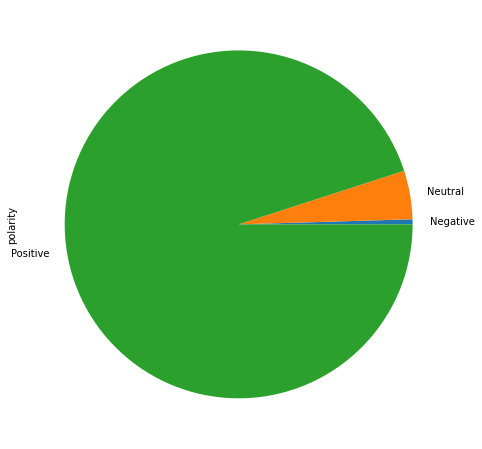

In [60]:
#Pie chart of polarity labels of users
user_average_polarity.groupby('Kind of user').count()["polarity"].plot(kind='pie', figsize=(8, 8))

#### Polarity of Twitter's users :

The graph above shows that most of the users are positive making from Twitter a positive platform.

#### 15. Match user and friends

In [61]:
friends_polarity = []
num_friends = []
for user_id in user_average_polarity['user_id']:
    #compute the average polarity of friends
    average_friends_polarity = np.nan
    num_friends_temp = np.nan
    friends_list = valid_friends.loc[valid_friends['id']  == user_id,'followingid'].values
    friends_tweets = friends_average_polarity.loc[friends_average_polarity['user_id'].isin(friends_list),'polarity']
    num_friends_temp = len(friends_tweets)
    average_friends_polarity = friends_tweets.mean()
    friends_polarity.append(average_friends_polarity)
    num_friends.append(num_friends_temp)

user_average_polarity['num_friends'] = np.array(num_friends)
user_average_polarity['friends_polarity'] = np.array(friends_polarity)

In [28]:
user_average_polarity

,user_id,retweet_count,favourite_count,polarity,Kind of user,num_friends,friends_polarity
0,52,40.888325,0.223350,0.117393,Positive,93,0.138767
1,35563,3916.233696,2.135870,0.101799,Positive,525,0.141106
2,1861461,156.466292,0.651685,0.126889,Positive,836,0.146308
3,5677342,609.335079,0.492147,0.176223,Positive,407,0.151523
4,6678622,328.617801,0.026178,0.014952,Positive,576,0.142167
...,...,...,...,...,...,...,...
637,2813674754,16035.970760,0.368421,0.108683,Positive,209,0.107240
638,2816038718,23303.826923,0.509615,0.093797,Positive,51,0.110609
639,2834237124,3255.654088,0.905660,0.117564,Positive,169,0.125597
640,2857164524,30.690722,0.077320,0.176345,Positive,29,0.111780


In [62]:
#Get the polarity label of friends
user_average_polarity['Kind of friend']=  np.array([polarity(score) for score in user_average_polarity['friends_polarity'] ])
user_average_polarity = user_average_polarity.dropna()
user_average_polarity

,user_id,retweet_count,favourite_count,polarity,Kind of user,num_friends,friends_polarity,Kind of friend
0,52,40.888325,0.223350,0.117393,Positive,93,0.138767,Positive
1,35563,3916.233696,2.135870,0.101799,Positive,525,0.141106,Positive
2,1861461,156.466292,0.651685,0.126889,Positive,836,0.146308,Positive
3,5677342,609.335079,0.492147,0.176223,Positive,407,0.151523,Positive
4,6678622,328.617801,0.026178,0.014952,Positive,576,0.142167,Positive
...,...,...,...,...,...,...,...,...
637,2813674754,16035.970760,0.368421,0.108683,Positive,209,0.107240,Positive
638,2816038718,23303.826923,0.509615,0.093797,Positive,51,0.110609,Positive
639,2834237124,3255.654088,0.905660,0.117564,Positive,169,0.125597,Positive
640,2857164524,30.690722,0.077320,0.176345,Positive,29,0.111780,Positive


#### 16. Analyse the similarity between the user polarity and its friends
    

In [65]:
#Check if the user and its friends have the same polarity label

user_average_polarity["equal"] = np.where(user_average_polarity['Kind of user'] == user_average_polarity['Kind of friend'], True, False)
user_average_polarity

<ipython-input-65-b59223255ebe>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_average_polarity["equal"] = np.where(user_average_polarity['Kind of user'] == user_average_polarity['Kind of friend'], True, False)


,user_id,retweet_count,favourite_count,polarity,Kind of user,num_friends,friends_polarity,Kind of friend,equal
0,52,40.888325,0.223350,0.117393,Positive,93,0.138767,Positive,True
1,35563,3916.233696,2.135870,0.101799,Positive,525,0.141106,Positive,True
2,1861461,156.466292,0.651685,0.126889,Positive,836,0.146308,Positive,True
3,5677342,609.335079,0.492147,0.176223,Positive,407,0.151523,Positive,True
4,6678622,328.617801,0.026178,0.014952,Positive,576,0.142167,Positive,True
...,...,...,...,...,...,...,...,...,...
637,2813674754,16035.970760,0.368421,0.108683,Positive,209,0.107240,Positive,True
638,2816038718,23303.826923,0.509615,0.093797,Positive,51,0.110609,Positive,True
639,2834237124,3255.654088,0.905660,0.117564,Positive,169,0.125597,Positive,True
640,2857164524,30.690722,0.077320,0.176345,Positive,29,0.111780,Positive,True


Text(0, 0.5, 'Number of users')

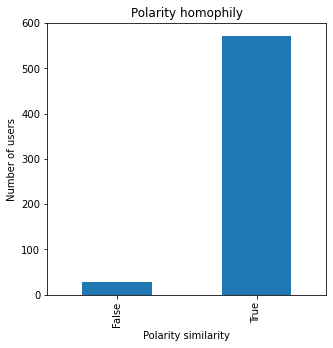

In [66]:
#Bar plot of similarity in polarity label between user and its friends
user_average_polarity.groupby('equal')['user_id'].count().plot.bar(title="Polarity homophily", figsize=(5,5))

plt.xlabel('Polarity similarity')
plt.ylabel('Number of users')
 

####  Homiphily of users:
    
The graph above shows that a user with a certain polarity tends to follow other users with the same polarity.

#### 17. Visualize the network of a user: 
    
A user ID was choosing  in order to show its polarity and also the polarity of its connections 

In [52]:

user_id =  2816038718 
friends_list = valid_friends.loc[valid_friends['id']  == user_id,'followingid'].values
friends_polarity =friends_average_polarity.loc[friends_average_polarity['user_id'].isin(friends_list),'Kind of friend']
friends_polarity= friends_polarity.to_frame().reset_index()


user = pd.DataFrame({'user_id': [user_id]})
user_repeated = pd.concat([user]*len(friends_polarity), ignore_index=True)

user_polarity = user_average_polarity.loc[user_average_polarity['user_id']== user_id, 'Kind of user'].values

user_polarity= pd.DataFrame({'user_polarity': user_polarity})

user_polarity_repeated = pd.concat([user_polarity]*len(friends_polarity), ignore_index=True)

df = pd.concat([user_repeated, user_polarity_repeated , friends_polarity], axis = 1)
df.rename(columns={'index': 'friend'}, inplace=True)


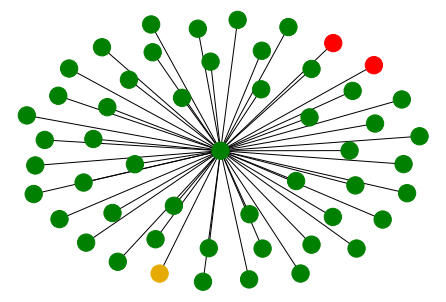

In [48]:
# Build your graph
# Positive friends are colored in green, negative friends in red and neutral ones in yellow
G=nx.from_pandas_edgelist(df, 'user_id', 'friend')
cbbPalette = ["#008000", "#FF0000", "#E6AB02", "#F0E442"]
values = np.where(df['Kind of friend']== 'Positive' , cbbPalette[0], 
         np.where(df['Kind of friend']== 'Negative', cbbPalette[1],
         np.where(df['Kind of friend']== 'Neutral', cbbPalette[2], cbbPalette[3])))

values = np.append(cbbPalette[0],values)
# Plot it
nx.draw(G, with_labels=False, node_color = values)
plt.show()

### Discussion

In this project, an extension of the concept of homophily presented in the paper “Testing Propositions Derived from Twitter Studies”, which is the tendency of individuals to bond with similar others.

The dataset provided was used in order to get the tweets of the users and their followees. Only the users that are still active in 2020 were selected and that have posted between 100 and 200 tweets in order to have a reasonable number of tweets to perform a sentiment analysis. Also, only english tweets were used. Hence, a great part of this work consisted of collecting the data that can allow us to perform the analysis.

The results showed that the majority of the users in the dataset are positive people. So, on Twitter, the users tend to share more positive content. However, this can be not totally accurate because some of the people use sarcasm to express their feelings and ideas so a positive content maybe a false positive one but it's hard to analyze this only by using a sentiment analysis. 

Furthermore; the users tend to follow others with same polarity as them. This result derives from the general polarity of Twitter. Indeed, since most of the users are positive then most of them have the same polarity.

#### Appendix A: TweetMiner Class Implementation

In [49]:
# -*- coding: utf-8 -*-
"""
Created on Wed Dec  9 19:18:00 2020

@author: Yuqi Wang
"""

from datetime import datetime
import tweepy

class TweetMiner(object):

    result_limit = 200
    key = 1
    data = list()
    api = False
    twitter_keys_1 = {'consumer_key': 'ao8r4omXvWJVqdDQDmHNTQro1',
                    'consumer_secret': 'jWpR3zUxY7s6jlelIYZbQ2CcIpVjU7bETjRY7QAr3gshDpLo8C',
                    'access_token_key': '1333883939056922624-yusW9NmGIO9YEcGaloDxAfk7q4CsxA',
                    'access_token_secret': 'Wc5hinGMMtDlzf3pQCTlZ8HfqXCVJKmgVZgioFHz4d36b'}
    
    twitter_keys_2 = {'consumer_key': 'Y536ojD2INATBY7x5GzJyxbcM',
                    'consumer_secret': 'hG3nZwXsxGa6iHP02zWgLHVk5boMxgvaASZsXOhyB9dPpagbKC',
                    'access_token_key': '1333373410664210435-qwPOR3gtUk8bzV3P2Ci96AeR7zzpcR',
                    'access_token_secret': 'l7LR5ymtTVTgdOQhD3GyHqsUWzAOkUDWNif72WdGCJ4HK'}    

    def __init__(self, keys_dict_1=twitter_keys_1,keys_dict_2=twitter_keys_2,api=api, result_limit=200, key=1):
        self.twitter_keys = keys_dict_1
        if key==2:
            print("Running with key 2")
            self.twitter_keys = keys_dict_2
        auth = tweepy.OAuthHandler(self.twitter_keys['consumer_key'],
                                   self.twitter_keys['consumer_secret'])
        auth.set_access_token(self.twitter_keys['access_token_key'],
                              self.twitter_keys['access_token_secret'])
        self.api = tweepy.API(auth, wait_on_rate_limit=True,
                              wait_on_rate_limit_notify=True)        
        self.result_limit = result_limit


    def mine_user_tweets(self, user_id):
        data = list()
        statuses = self.api.user_timeline(user_id=user_id,count=self.result_limit,
                                          tweet_mode = 'extended',include_retweets=True)
        for item in statuses:
            mined = {'tweet_id': item.id,
            'user_id': user_id,
            'retweet_count': item.retweet_count,
            'text': str(item.full_text),
            'created_at': item.created_at,
            'favourite_count': item.favorite_count,
            'language': item.lang}
            try:
                mined['retweet_text'] = str(item.retweeted_status.full_text)
            except:
                mined['retweet_text'] = 'None'
            data.append(mined)
            
        return data